In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
folder = '/Users/hoale/Code/MA_Weather/'
df = pd.DataFrame()

for dirname, _, filenames in os.walk(folder):
    for filename in filenames:
        if filename.endswith('.csv'):
            dfx = pd.read_csv(os.path.join(dirname, filename))
            df = pd.concat([df, dfx], axis=0)

In [3]:
df.head(5)

,EVENT_ID,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,BEGIN_TIME,EVENT_TYPE,MAGNITUDE,TOR_F_SCALE,DEATHS_DIRECT,INJURIES_DIRECT,...,END_LOCATION,END_DATE,END_TIME,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EVENT_NARRATIVE,EPISODE_NARRATIVE,ABSOLUTE_ROWNUMBER
0,1155403,NORTHERN BERKSHIRE (ZONE),,01/06/2024,1600,Heavy Snow,,,0,0,...,,01/07/2024,1900,,,,,NaN,An area of low pressure slowly tracking up and...,1
1,1155404,SOUTHERN BERKSHIRE (ZONE),,01/06/2024,1600,Heavy Snow,,,0,0,...,,01/07/2024,1900,,,,,NaN,An area of low pressure slowly tracking up and...,2
2,1147150,EASTERN FRANKLIN (ZONE),,01/06/2024,2300,Heavy Snow,,,0,0,...,,01/07/2024,1700,,,,,Generally 8 to 15 inches of snow fell. Some hi...,A strong storm moved up the east coast passing...,3
3,1147157,EASTERN HAMPSHIRE (ZONE),,01/06/2024,2300,Heavy Snow,,,0,0,...,,01/07/2024,1700,,,,,Generally 10 to 15 inches of snow fell. Some a...,A strong storm moved up the east coast passing...,4
4,1147149,WESTERN FRANKLIN (ZONE),,01/06/2024,2300,Heavy Snow,,,0,0,...,,01/07/2024,1600,,,,,Generally 8 to 14 inches of snow fell. Some sn...,A strong storm moved up the east coast passing...,5


In [4]:
df.describe()

,EVENT_ID,BEGIN_TIME,DEATHS_DIRECT,INJURIES_DIRECT,DAMAGE_PROPERTY_NUM,DAMAGE_CROPS_NUM,EPISODE_ID,CZ_FIPS,INJURIES_INDIRECT,DEATHS_INDIRECT,END_TIME,ABSOLUTE_ROWNUMBER
count,3.503000e+03,3503.000000,3503.000000,3503.000000,3.503000e+03,3503.000000,3503.00000,3503.000000,3503.000000,3503.0,3503.000000,3503.000000
mean,9.662755e+05,1329.937482,0.001427,0.007708,1.606300e+04,62.018270,159580.78390,14.631173,0.000571,0.0,1403.778761,203.770482
std,1.109303e+05,607.640436,0.037759,0.129569,5.158491e+05,3380.225571,17005.50463,8.015289,0.033792,0.0,564.923792,124.574590
min,7.947470e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,132827.00000,1.000000,0.000000,0.0,0.000000,1.000000
25%,8.694370e+05,914.500000,0.000000,0.000000,0.000000e+00,0.000000,144786.00000,8.000000,0.000000,0.0,1100.000000,98.000000
50%,9.386910e+05,1503.000000,0.000000,0.000000,5.000000e+02,0.000000,155486.00000,15.000000,0.000000,0.0,1535.000000,195.000000
75%,1.052314e+06,1743.000000,0.000000,0.000000,1.300000e+03,0.000000,173290.00000,21.000000,0.000000,0.0,1800.000000,303.000000
max,1.206608e+06,2352.000000,1.000000,5.000000,3.000000e+07,200000.000000,195143.00000,27.000000,2.000000,0.0,2359.000000,480.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3503 entries, 0 to 366
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   EVENT_ID             3503 non-null   int64 
 1   CZ_NAME_STR          3503 non-null   object
 2   BEGIN_LOCATION       3503 non-null   object
 3   BEGIN_DATE           3503 non-null   object
 4   BEGIN_TIME           3503 non-null   int64 
 5   EVENT_TYPE           3503 non-null   object
 6   MAGNITUDE            3503 non-null   object
 7   TOR_F_SCALE          3503 non-null   object
 8   DEATHS_DIRECT        3503 non-null   int64 
 9   INJURIES_DIRECT      3503 non-null   int64 
 10  DAMAGE_PROPERTY_NUM  3503 non-null   int64 
 11  DAMAGE_CROPS_NUM     3503 non-null   int64 
 12  STATE_ABBR           3503 non-null   object
 13  CZ_TIMEZONE          3503 non-null   object
 14  MAGNITUDE_TYPE       3503 non-null   object
 15  EPISODE_ID           3503 non-null   int64 
 16  CZ_TYPE     

In [6]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [12]:
# Standardize the time columns
df['begin_time'] = df['begin_time'].astype(str)
df['end_time'] = df['end_time'].astype(str)
df['begin_time'] = df['begin_time'].str.pad(width=4, side='left', fillchar='0')
df['end_time'] = df['end_time'].str.pad(width=4, side='left', fillchar='0')

# Change date and time format
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['begin_time'] = pd.to_datetime(df['begin_time'], format='%H%M')
df['end_time'] = pd.to_datetime(df['end_time'], format='%H%M')

# Create new features
df['month'] = df['begin_date'].dt.month
df['year'] = df['begin_date'].dt.year
df['day'] = df['begin_date'].dt.day
df['begin'] = df['begin_date'] + pd.to_timedelta(df['begin_time'].dt.hour, unit='h') + pd.to_timedelta(df['begin_time'].dt.minute, unit='m')
df['end'] = df['end_date'] + pd.to_timedelta(df['end_time'].dt.hour, unit='h') + pd.to_timedelta(df['end_time'].dt.minute, unit='m')
df['duration'] = df['end'] - df['begin']
df['type'] = np.where((df['episode_narrative'].str.contains('heavy snow', case=False, na=False)) | (df['event_type']=='Heavy Snow'), 'Heavy Snow', 'Other')

In [21]:
df.head(5).T

,0,1,2,3,4
event_id,1155403,1155404,1147150,1147157,1147149
cz_name_str,NORTHERN BERKSHIRE (ZONE),SOUTHERN BERKSHIRE (ZONE),EASTERN FRANKLIN (ZONE),EASTERN HAMPSHIRE (ZONE),WESTERN FRANKLIN (ZONE)
begin_location,,,,,
begin_date,2024-01-06 00:00:00,2024-01-06 00:00:00,2024-01-06 00:00:00,2024-01-06 00:00:00,2024-01-06 00:00:00
begin_time,1900-01-01 16:00:00,1900-01-01 16:00:00,1900-01-01 23:00:00,1900-01-01 23:00:00,1900-01-01 23:00:00
event_type,Heavy Snow,Heavy Snow,Heavy Snow,Heavy Snow,Heavy Snow
magnitude,,,,,
tor_f_scale,,,,,
deaths_direct,0,0,0,0,0
injuries_direct,0,0,0,0,0


# Which event types happened the most

In [245]:
sns.set_palette("bright")
sns.set_theme(font_scale=1.2, style='dark',)

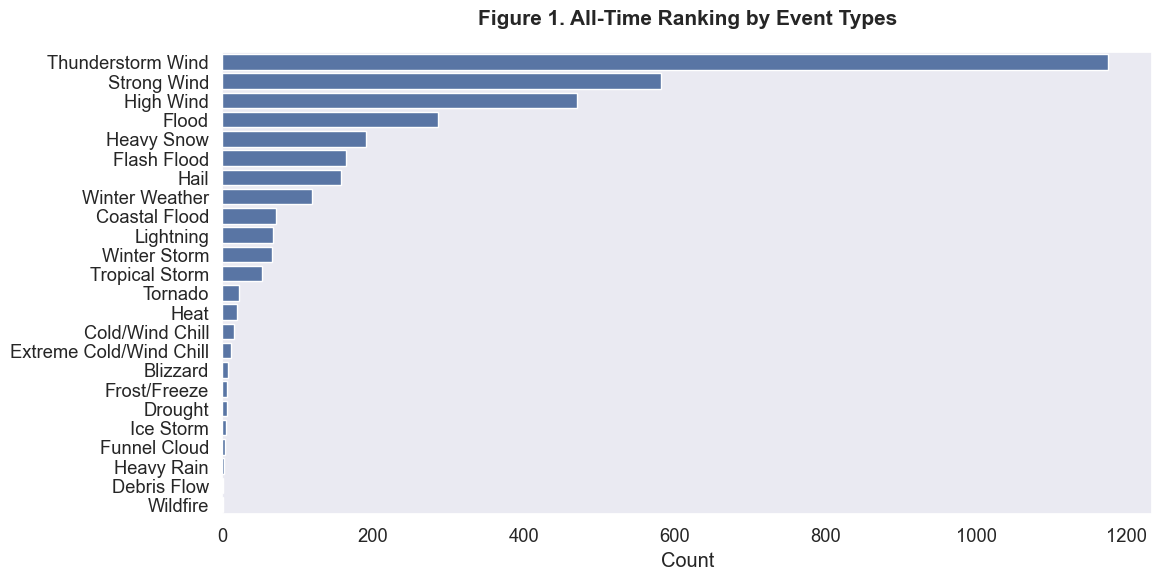

In [254]:
sns.barplot(y=df['event_type'].value_counts().index, x=df['event_type'].value_counts().values)
plt.ylabel('')
plt.xlabel('Count')
plt.title('Figure 1. All-Time Ranking by Event Types', pad=20, fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.show()

# What are the trends of events

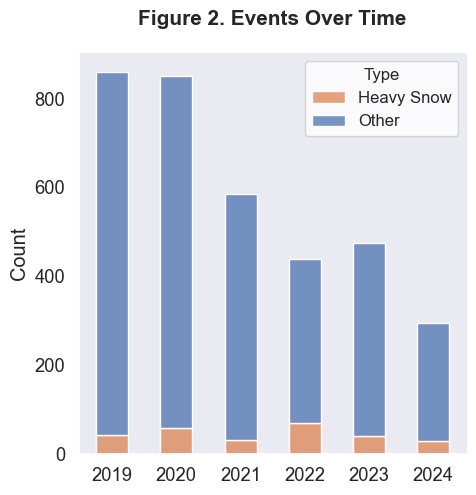

In [253]:

sns.displot(x=df['year'], discrete=True, shrink=.5, hue=df['type'], multiple='stack', hue_order=['Other', 'Heavy Snow'], legend=False,)
plt.ylabel('Count')
plt.xlabel('')
plt.legend(title='Type', loc='upper right', labels=['Heavy Snow', 'Other'], fontsize=12, title_fontsize=12, facecolor='white', )
plt.title('Figure 2. Events Over Time', pad=20, fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.show()


- Total number of events decreased by about 50% (2024 data is not up to date, i.e. lacking data after August 31st).
- 2022 is the year with the most heavy snow events. It then decreased over time. 

# How long do heavy snow events last?

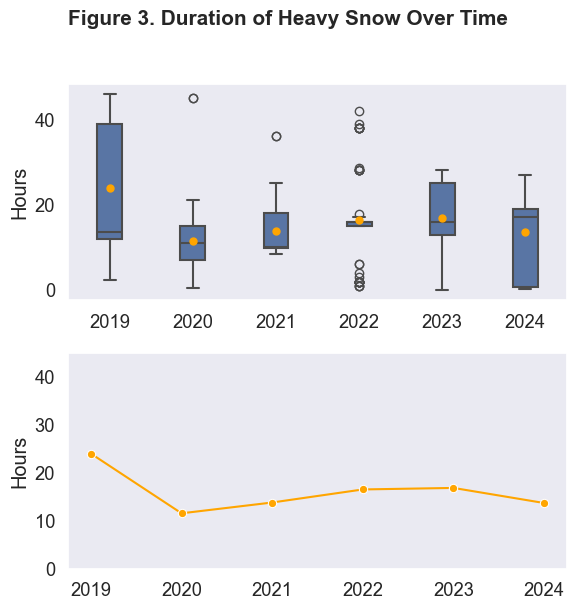

In [252]:
hs = df[df['type']=='Heavy Snow']
fig, axs = plt.subplots(2, 1, figsize=(6, 6), )
sns.boxplot(x=hs['year'], y=hs['duration'].dt.total_seconds()/3600, width=0.3, linewidth=1.5,  
            meanline=False, showmeans=True, meanprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'orange', 'markeredgecolor': 'orange'}, ax=axs[0])
sns.lineplot(x=hs['year'], y=hs['duration'].dt.total_seconds()/3600, estimator='mean', errorbar=None, marker='o', ax=axs[1], color='orange', )
axs[1].set_ylim(0, 45)
axs[0].set_ylabel('Hours')
axs[0].set_xlabel('')
axs[1].set_ylabel('Hours')
axs[1].set_xlabel('')
fig.suptitle('Figure 3. Duration of Heavy Snow Over Time', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

- The duration of heavy snow events varied from a few hours to more than a day. 
- The average duration increased slightly from 2020 to 2023, each year by 2 hours longer. Data for 2024 may not be sufficient.
- Although the number of heavy snow events in 2022 was the highest (Figure ), the average duration was lower than that in 2019.

# Which areas had the most events? What damages did they have?

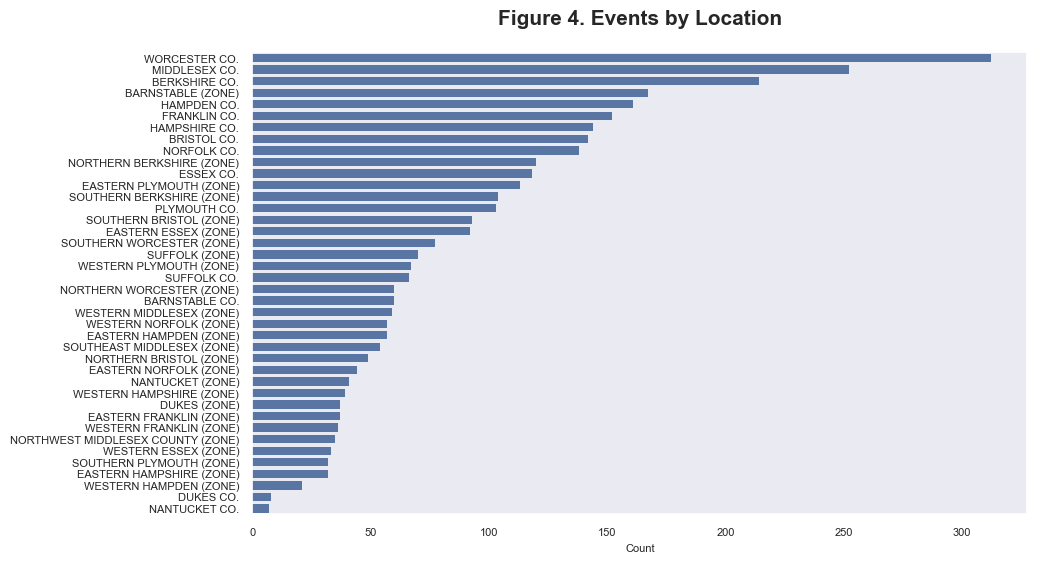

In [356]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='cz_name_str', order=df['cz_name_str'].value_counts(ascending=False).index, edgecolor='None', gap=0.1,)
plt.ylabel('')
plt.xlabel('Count', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Figure 4. Events by Location', pad=20, fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.show()


# Does heavy snow has correlation with any other event types?

# What usually come after heavy snow, if anything?